In [12]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1";

import numpy as np
import torch
from torchvision import models
import torch.backends.cudnn as cudnn
from utils import *
from brusleattack import BruSLeAttack
from matplotlib import pyplot as plt
from torchvision.utils import save_image

In [2]:
def imshow(img):
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

### 1. On ImageNet - Targeted Attack

In [3]:
flag = True # True for targeted attack; False for untargeted attack
arch = 'resnet50'
dataset = 'imagenet'

# Load model
net = load_model(arch)
model = PretrainedModel(net,dataset)

# Load data
_, testset = load_data(dataset,batch_size=1)
ID_set = get_evalset(dataset, arch,flag)

In [4]:
# hyper-parameters for BruSLeAttack
lamda = 0.05
ftype = 'ce'
pop_size = 10
max_query = 10000
m1 = 0.24
m2 = 0.997

# hyper-parameter for synthetic color image
scale = 1
scale_mode = 'INTER_NEAREST'
mode = 'uni' 
seed = 10

In [5]:
n = 100 # number of perturbed pixels
attack = BruSLeAttack(model,n,pop_size,lamda,m1,m2,seed,flag,ftype)

In [21]:
# 0. select original image
o = 20150 #32725 #45964 #3224 
img, olabel = testset[o]
oimg = torch.unsqueeze(img, 0).cuda()

# 1. select starting image
tlabel = 620 #895 #920 #113 
timg = search_space_init(oimg,seed,scale,mode,scale_mode)
            
# 2. Run attack
adv,nqry,dist = attack.perturb(oimg,timg,olabel,tlabel,max_query)

# 3. check and display
alabel = model.predict_label(adv).item()     

print(f'oID:{o}, olabel:{olabel}, o_pred:{model.predict_label(oimg).item()}; tlabel: {tlabel}; alabel: {alabel}; nqry:{nqry}, dist:{dist}')


attack successful at 191, adv label: 620; tlabel=620; f_mg=0.0
oID:20150, olabel:403, o_pred:403; tlabel: 620; alabel: 620; nqry:191, dist:100


Sparse Adversarial Example


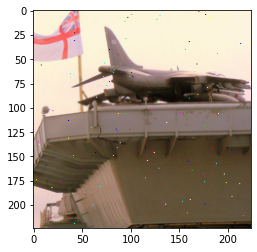

Sparse Perturbation


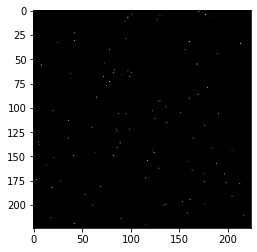

In [24]:
print('Sparse Adversarial Example')
imshow(adv.cpu()) 
print('Sparse Perturbation')
imshow(torch.abs(oimg- adv).cpu()) 

In [23]:
path = 'Imagenet_ID'+str(o)+'_tlabel_'+str(tlabel)+'_alabel_'+str(alabel)+'_budget_'+str(n)
save_image(adv, path+'.png')
save_image(torch.abs(oimg- adv), path+'_abs.png')

### 2. On ImageNet - Untargeted Attack

In [25]:
flag = False # True for targeted attack; False for untargeted attack
arch = 'resnet50'
dataset = 'imagenet'

# Load model
net = load_model(arch)
model = PretrainedModel(net,dataset)

# Load data
_, testset = load_data(dataset,batch_size=1)
ID_set = get_evalset(dataset, arch,flag)

In [26]:
# hyper-parameters for BruSLeAttack
lamda = 0.3
ftype = 'margin'
pop_size = 10
max_query = 5000
m1 = 0.24
m2 = 0.997

# hyper-parameter for synthetic color image
scale = 1
scale_mode = 'INTER_NEAREST'
mode = 'uni' 
seed = 10

In [50]:
n = 10 # number of perturbed pixels
attack = BruSLeAttack(model,n,pop_size,lamda,m1,m2,seed,flag,ftype)

In [61]:
# 0. select original image
o = 3224  #20150 #32725 #45964 #
img, olabel = testset[o]
oimg = torch.unsqueeze(img, 0).cuda()

# 1. select starting image
tlabel = None
timg = search_space_init(oimg,seed,scale,mode,scale_mode)
            
# 2. Run attack
adv,nqry,dist = attack.perturb(oimg,timg,olabel,tlabel,max_query)

# 3. check and display
alabel = model.predict_label(adv).item()     

print(f'oID:{o}, olabel:{olabel}, o_pred:{model.predict_label(oimg).item()}; alabel: {alabel}; nqry:{nqry}, dist:{dist}')


attack successful at 3184, adv label: 55; tlabel=None; f_mg=-0.019336670637130737
oID:3224, olabel:64, o_pred:64; alabel: 55; nqry:3184, dist:10


Sparse Adversarial Example


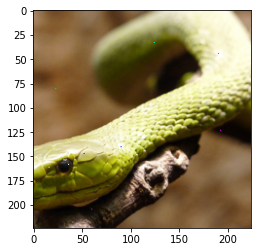

Sparse Perturbation


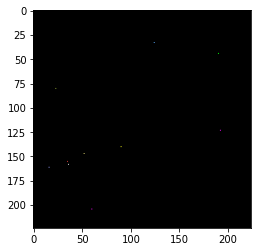

In [67]:
print('Sparse Adversarial Example')
imshow(adv.cpu()) 
print('Sparse Perturbation')
imshow(torch.abs(oimg- adv).cpu()) 

In [63]:
path = 'Imagenet_ID'+str(o)+'_olabel_'+str(olabel)+'_alabel_'+str(alabel)+'_budget_'+str(n)
save_image(adv, path+'.png')
save_image(torch.abs(oimg- adv), path+'_abs.png')